In [1304]:
import pandas as pd
import re
import numpy as np
from time import time 
from datetime import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.cluster import KMeans
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1393]:
tweets_user = pd.read_csv('/Users/Noelia/Desktop/DATA_IRONHACK/FINAL_PROJECT/final_project_ironhack/output/User_csv/@mew4teaching_tweets.csv')

In [1306]:
tweets_user.head()

,id,created_at,text
0,1150449670780534786,2019-07-14 16:59:10,RT @fredmercurys: 34 years ago today one man s...
1,1141010929242517505,2019-06-18 15:52:59,"RT @USATODAY: ""There's so much more work to do..."
2,1140306426809802753,2019-06-16 17:13:32,RT @CBSSunday: World's best dads\n\nFather's D...
3,1138114066982084608,2019-06-10 16:01:53,RT @wirecutter: 5 Wirecutter-recommended produ...
4,1136630931547131904,2019-06-06 13:48:26,Cincinnati: A Great American City Roars Back h...


In [1307]:
#tweet_text = tweets_user[['text']]

In [1308]:
def retweet(input_text):
    if input_text.startswith("RT"):
        value = 1
    else:
        value = 0
    return value

In [1309]:
tweets_user['RT'] = tweets_user.text.apply(retweet)

In [1310]:
tweets_user['mention'] = tweets_user.text.str.findall(r'(?<![@\w])@(\w{1,25})').apply(', '.join)

In [1311]:
tweets_user['hashtag'] = tweets_user.text.str.extract(r'(\#\w+)', expand=False)

In [1312]:
tweets_user['hashtag'] = tweets_user['hashtag'].fillna("")

In [1313]:
#def remove_characters(input_text):
#    list_remove = ["RT", "(?<![@\w])@(\w{1,25})", "\#+"]
#    for charac in list_remove:
#        input_text = re.sub(charac, '', input_text)
#    return input_text.lower()
#def remove_special_characters(data, colum):
#    input_text = data[colum].str.replace("[\d\W_]+", " ", re.UNICODE)
#    return input_text
#def deEmojify(inputString):
 #   return inputString.encode('latin-1', 'ignore').decode('latin-1')#

In [1314]:
#def removeSpace(x):
 #       return " ".join([w for w in x.split() if len(w)>3])

In [1315]:
#tweets_user['cleaned_tweets'] = tweets_user.text.apply(remove_characters)

In [1316]:
#tweets_user[['cleaned_tweets']].head()

In [1317]:
#tweets_user['cleaned_tweets'] = tweets_user['cleaned_tweets'].str.replace('http\S+|www.\S+', "")

In [1318]:
#tweets_user['cleaned_tweets'] = remove_special_characters(tweets_user, "cleaned_tweets")

In [1319]:
#tweets_user['cleaned_tweets'] = tweets_user['cleaned_tweets'].apply(deEmojify)

In [1320]:
#tweets_user['cleaned_tweets'] = tweets_user['cleaned_tweets'].apply(removeSpace)

In [1321]:
#tweets_user['cleaned_tweets']

In [1322]:
#def remove_characters(input_text):
 #   list_remove = ["RT", "@", "\#+", 'http\S+|www.\S+']
  #  for charac in list_remove:
   #     input_text = re.sub(charac, '', input_text)
   # return input_text.lower()

In [1323]:
#tweets_user['tokenized'] = tweets_user['text'].apply(spacy_tokenizer)

In [1324]:
#tweets_user = tweets_user[tweets_user['tokenized'].map(lambda d: len(d)) > 0]

In [1325]:
#tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [1326]:
#vector2 = bow_vector.fit_transform(all_tweets)

In [1327]:
tweets_user['date'] = tweets_user['created_at']

In [1328]:
tweets_user['date'] = pd.DatetimeIndex(tweets_user['created_at']).to_period('D')

In [1329]:
tweets_user = tweets_user.drop(columns=["created_at"], axis=1)

In [1330]:
#tweets_user = tweets_user[["id", "date", "mention", "hashtag", "RT", "cleaned_tweets"]]

In [1331]:
#def tokenize(s):
    #return s.split(" ") 

In [1332]:
nlp = spacy.load('en')

# English tokenizer, tagger, parser, NER and word vectors
parser = English()

In [1333]:
nlp.Defaults.stop_words |= {"rt","amp","xx", "xxx"}

In [1334]:
#nlp.Defaults.stop_words.add([["rt", "amp"]])

In [1335]:
def spacy_tokenizer(sentence):
    #sentence = remove_characters(sentence) 
   # sentence = sentence.replace('http\S+|www.\S+', "") 
    tokens = parser(sentence)
    filtered_tokens = []
    for word in tokens:
        lemma = word.lemma_.lower().strip()
        
        if lemma not in STOP_WORDS and re.search('^[a-zA-Z]{2}', lemma):
            filtered_tokens.append(lemma)

    return filtered_tokens

#" ".join([token.lemma_ for token in doc])


#if word.lemma_ != "-PRON-" else word.lower_

In [1336]:
tweets_user['tokenized'] = tweets_user['text'].apply(spacy_tokenizer)

In [1338]:
num_features = 300
min_word_count = 50
num_workers = multiprocessing.cpu_count()
context_size = 10
downsampling = 1e-4
seed = 2

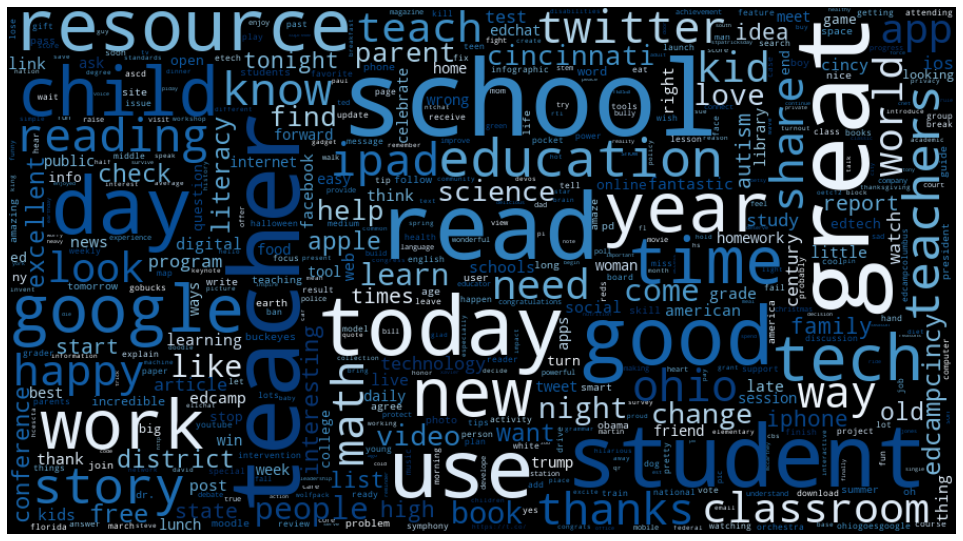

In [1339]:
all_words = []
for line in tweets_user['tokenized']: # try 'tokens'
    all_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [1340]:
#def tokenize_only(text):
 #   tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
  #  filtered_tokens = []
    #filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
   # for token in tokens:
  #      if re.search('[a-zA-Z]', token):
    #        filtered_tokens.append(token)
   # return filtered_tokens

In [1341]:
#totalvocab_stemmed = []
#totalvocab_tokenized = []
#for i in tweets_user['text']:
 #   allwords_stemmed = tokenize_and_stem(i)
  #  totalvocab_stemmed.extend(allwords_stemmed)
    
   # allwords_tokenized = tokenize_only(i)
   # totalvocab_tokenized.extend(allwords_tokenized)

In [1342]:
#vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
#print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

In [1343]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer, min_df=3)

%time tfidf_matrix = tfidf_vectorizer.fit_transform(tweets_user['text'].values)

print(tfidf_matrix.shape)

CPU times: user 624 ms, sys: 6.49 ms, total: 630 ms
Wall time: 632 ms
(1542, 832)


In [1344]:
terms = tfidf_vectorizer.get_feature_names()

In [1345]:
array_matrix = tfidf_matrix.toarray()

In [1346]:
first_vector_tfidfvectorizer=tfidf_matrix[0]
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head()

,tfidf
ago,0.490678
single,0.490678
man,0.440157
world,0.357692
year,0.327360


In [1347]:
vocab = tfidf_vectorizer.vocabulary_

In [1348]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
dist

array([[ 0.00000000e+00,  8.93298959e-01,  9.11971825e-01, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 8.93298959e-01,  0.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 9.11971825e-01,  1.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       ...,
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
        -2.22044605e-16,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00, -2.22044605e-16]])

In [1349]:
from mpl_toolkits.mplot3d import Axes3D
import umap

In [1350]:
umap = UMAP(n_components=2, n_neighbors=8)
embedding = umap.fit_transform(dist)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


In [1351]:
umap_df = pd.DataFrame(embedding, columns=[f'emb_{i+1}' for i in range(2)])

In [1352]:
umap_df.head()

,emb_1,emb_2
0,-23.681171,35.681282
1,-25.101242,34.563938
2,-18.519573,31.856121
3,-25.346670,34.296021
4,-19.417347,32.545670


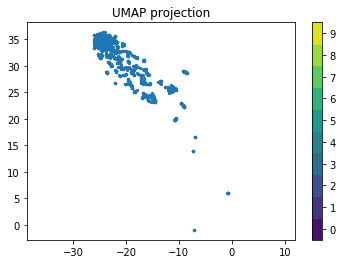

In [1353]:
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection', fontsize=12);

In [1386]:
from hdbscan import HDBSCAN
    
hdbscan = HDBSCAN(min_cluster_size=30, gen_min_span_tree=True, metric='braycurtis')

clustering = hdbscan.fit_predict(embedding)

np.unique(clustering)

array([-1,  0,  1,  2,  3,  4,  5])

In [1387]:
hdbscan.labels_.max()

5

In [1356]:
labels = hdbscan.labels_
labels

array([ 3,  3, -1, ...,  3, -1,  5])

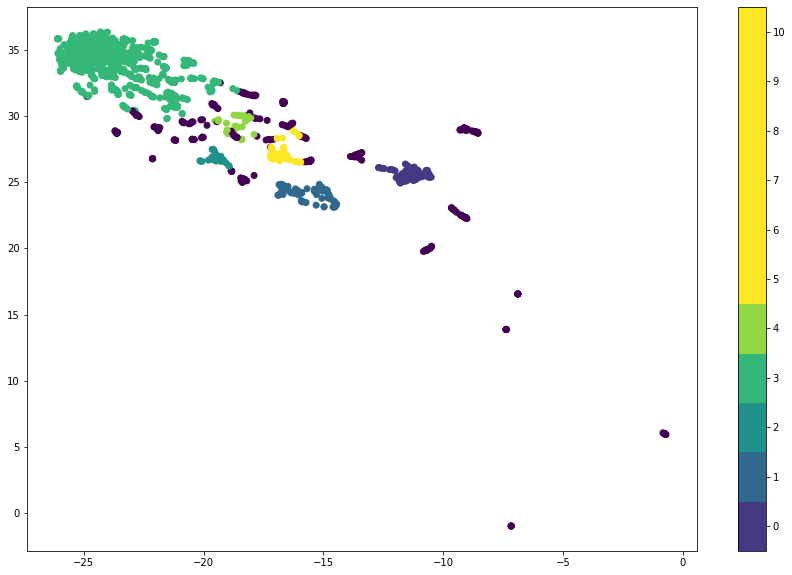

In [1357]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(embedding[:,0], embedding[:,1], c=clustering);
plt.colorbar(boundaries=np.arange(12)-0.5).set_ticks(np.arange(11))

In [1358]:
from sklearn.metrics import silhouette_score

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(embedding, hdbscan.fit_predict(embedding)))

Silhouette Coefficient: 0.382


In [1359]:
from mpl_toolkits.mplot3d import Axes3D

In [1360]:
from sklearn.cluster import KMeans

num_clusters = 9

km = KMeans(n_clusters=num_clusters)

%time km.fit(embedding)

clusters = km.labels_.tolist()

CPU times: user 98.5 ms, sys: 2.67 ms, total: 101 ms
Wall time: 109 ms


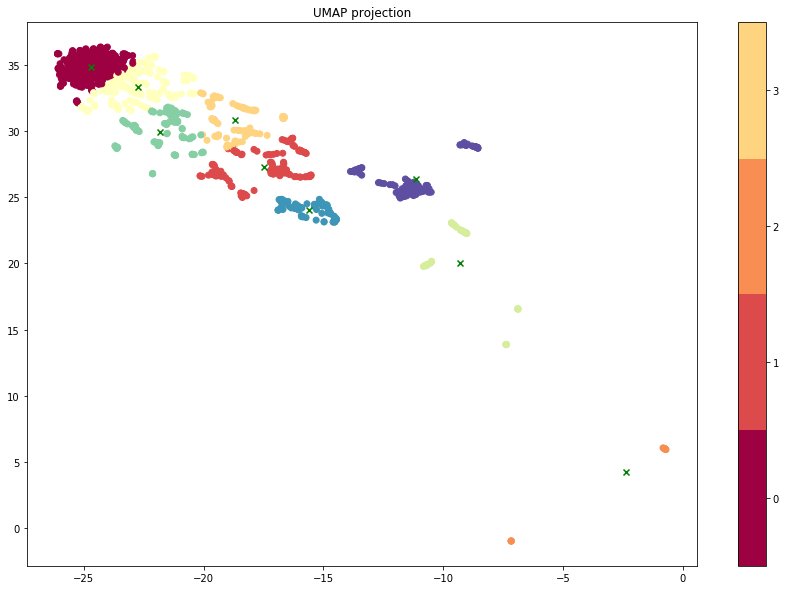

In [1361]:
from matplotlib.pyplot import figure
fig = plt.figure(figsize=(15, 10))
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], c =km.labels_, cmap='Spectral')
#plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(5)-0.5).set_ticks(np.arange(4))
centers = np.array(km.cluster_centers_)

#This array is one dimensional, thus we plot it using:
plt.scatter(centers[:,0], centers[:,1], marker="x", color='green')
plt.title('UMAP projection', fontsize=12);

In [1362]:
from sklearn.metrics import silhouette_score

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(embedding, km.predict(embedding)))

Silhouette Coefficient: 0.474


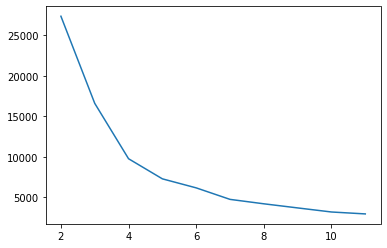

In [1363]:
inertia = []

for n_clusters in range(2, 12):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    inertia.append(kmeans.inertia_)
    
plt.plot(range(2, 12), inertia);

In [1364]:
tweets = {'tweet': tweets_user['text'].values,  'cluster': clusters}
frame = pd.DataFrame(tweets, index = [clusters] , columns = ['tweet', 'cluster'])

In [1365]:
frame[frame['cluster']==1].head()

,tweet,cluster
1,Good read: https://t.co/DXlnnOejN9,1
1,Say goodbye to the tech that died this year vi...,1
1,RT @garystager: Got socks or other crappy gift...,1
1,The 20 best tech gadget gifts under $25 https:...,1
1,Back-to-School Tech Guide 2017 - CNET https://...,1


In [1366]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
tfidf_df.head()

,able,abt,academic,academy,access,achievement,act,action,activity,actually,...,xavier,year,yes,yesterday,yikes,york,young,youtube,yr,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.327360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.325945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1367]:
def get_df_from_cluster(cluster):
    return tfidf_df[clustering==cluster]

In [1374]:
top_words_cluster = get_df_from_cluster(5).T.sum(axis=1).sort_values(ascending=False)
top_words_cluster.head()

read        14.160813
tech         6.296180
book         2.999174
interest     2.828582
math         2.457635
dtype: float64

In [1395]:
#test_labels, strengths = hdbscan.approximate_predict(hdbscan, embedding)